A overview of the project:

- [ ] Step1: Generate order parameters maps and supercurrent maps.
- [ ] Step2: Construct machine learning model architecture
- [ ] Step3: Train the model
- [ ] Step4: Test the model

## Step1: Generate order parameters and super current maps

We consider the simplest model first:
\begin{equation}
   \hat{h} = \left( a k_x + i b k_y \right)^n \hat{\sigma}_+ + \left( a k_x - ib k_y \right)^n \hat{\sigma}_-
\end{equation}

In [1]:
%reload_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_AI4Top/Top-invar-DL'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)
import sys
sys.path.append(GOOGLE_DRIVE_PATH)
import torch
if torch.cuda.is_available:
  device = 'cuda'
  print('Good to go')
else:
  device = 'cpu'
  print('Please set GPU via Edit -> Notebook Settings')

Mounted at /content/drive
drive/My Drive/My_AI4Top/Top-invar-DL
Good to go


In [ ]:
import numpy as np
import pandas as pd
from Dirac_Current import *
import functools
import time

We use following expressions for computing the superfluid stiffness of above continuous model. The total superfluid stiffness is given by
\begin{equation}
     D_{xx} = 2 \Delta^2 \int^{\pi}_{-\pi} \frac{dk_x}{2 \pi} \frac{dk_y}{2 \pi} \sum_{\alpha,\beta} \frac{\left\vert \langle u_{\alpha} \left\vert \partial_{k_x} \hat{h} \right\vert u_{\beta} ⟩  \right\vert^2}{E^2_{\alpha} - E^2_{\beta}} \left[ \frac{f_\beta}{E_\beta} - \frac{f_\alpha}{E_\alpha} \right],
\end{equation}
which contain two components: the intra-band contribution

$$D_{\textrm{intra}} = \frac{a}{b} n \frac{\sqrt{\mu^2+\Delta^2}}{2\pi}\Bigg\{ \Theta(|\Delta|-|B|)+\Theta(|B|-|\Delta|)\Theta(\sqrt{\mu^2+\Delta^2}-|B|) \bigg[1-\frac{|\mu|}{\sqrt{\mu^2+\Delta^2}}\frac{|B|}{\sqrt{B^2-\Delta^2}}\bigg]\Bigg\}$$

and the inter-band contribution
$$D_{\textrm{inter}} = \frac{a}{b} n \frac{|\Delta|}{2\pi}\frac{|\Delta|}{|\mu|} \Bigg\{ \Theta(|\Delta|-|B|)\ln(\frac{\sqrt{\mu^2+\Delta^2}+|\mu|}{|\Delta|})+\Theta(|B|-|\Delta|)\Theta(\sqrt{\mu^2+\Delta^2}-|B|)\ln(\frac{\sqrt{\mu^2+\Delta^2}+|\mu|}{\sqrt{B^2-\Delta^2}+|B|}) \Bigg\}$$
when $\mu \to 0$, $D_{\textrm{inter}}=\frac{a}{b}n\frac{|\Delta|}{2\pi}\Theta(|\Delta|-|B|) $

where $ \left\vert \overline{k}  \right\vert = \sqrt{a^2 k_x^2 + b^2 k_y^2}   $, $ E_{\pm} = \sqrt{(\left\vert \overline{k}   \right\vert^n \pm \mu )^2 + \Delta^2}  $, $ f(E) = \Theta(B+E)-\Theta(B-E)  $

In [ ]:
%%time
from Dirac_model_analytic_broken import *
#torch.set_printoptions(sci_mode=False)
device = 'cuda'
B_steps = 15
mu_steps = 15

winding_array = torch.arange(1,10)
# winding_array = torch.arange(1,2)
winding_unique = winding_array.shape[0]
Delta = torch.ones(1)
a_div_b = 1
B = torch.linspace(-2,2,steps=B_steps)
mu0 = torch.linspace(-5,5,501)
mu_offset_array = torch.linspace(-2,2,steps=mu_steps)
mu_random = mu0.shape[0]



'''
Compute Superfluid stiffness for each truck
'''
D_generator = Analytic_D(winding_array,mu0,mu_offset_array,B,device=device)
D_total = D_generator.total().to(device='cpu')
D_total_trivial = D_generator.trivial().to(device='cpu')
torch.cuda.empty_cache()

label_mask = (abs(mu0)<=2).repeat(winding_unique,1).reshape(-1,1)
labels = label_mask*(winding_array.repeat_interleave(mu_random).reshape(-1,1))
labels_trivial = torch.zeros(1,mu_random).reshape(-1,1)
# label_mask = (abs(mu0)<=2).repeat(winding_unique,1).reshape(-1,1)
# labels = torch.cat( (label_mask*(winding_array.repeat_interleave(mu_random).reshape(-1,1)),mu0.repeat(winding_unique).reshape(-1,1)),dim=1)
# labels_trivial = torch.cat((torch.zeros(1,mu_random).reshape(-1,1),mu0.reshape(-1,1)),dim=1)

D_total = (torch.pi/Delta)*torch.cat((D_total_trivial,D_total),dim=0)
labels = torch.cat((labels_trivial,labels),dim=0).reshape(-1)
print(D_total.shape)
print(labels.shape)

torch.Size([10, 501, 15, 15])
torch.Size([5010])
CPU times: user 6.32 ms, sys: 1.99 ms, total: 8.3 ms
Wall time: 8.24 ms


In [ ]:
D_total_path = os.path.join(GOOGLE_DRIVE_PATH,'D_total_tensor_S_broken.pt')
label_path = os.path.join(GOOGLE_DRIVE_PATH,'label_S_broken.pt')
# D_total_path_l = os.path.join(GOOGLE_DRIVE_PATH,'D_total_tensor_l_S.pt')
# label_path_l = os.path.join(GOOGLE_DRIVE_PATH,'label_l_S.pt')
torch.save(D_total,D_total_path)
torch.save(labels,label_path)
print('max:',D_total.max(),'min:',D_total.min())

max: tensor(33.5196) min: tensor(-31.8862)


In [2]:
D_total_path = os.path.join(GOOGLE_DRIVE_PATH,'D_total_tensor_S_broken.pt')
label_path = os.path.join(GOOGLE_DRIVE_PATH,'label_S_broken.pt')
# D_total_path = os.path.join(GOOGLE_DRIVE_PATH,'D_total_tensor_S.pt')
# label_path = os.path.join(GOOGLE_DRIVE_PATH,'label_S.pt')
D_total = torch.load(D_total_path)
labels = torch.load(label_path)
#D_total_l = torch.load(D_total_path_l)
#labels_l = torch.load(label_path_l)
winding_u= D_total.shape[0]
mu_random = D_total.shape[1]
B_steps = D_total.shape[2]
mu_steps = D_total.shape[3]
#mu_random_l = D_total_l.shape[0]
print('D_total shape:',D_total.shape)
print('lables shape:',labels.shape)
print('D_total max:',D_total.max(),'D_total min:',D_total.min())
#print('D_total_1 shape:',D_total_l.shape)
#print('labels shape:',labels_l.shape)

D_total shape: torch.Size([10, 501, 15, 15])
lables shape: torch.Size([5010])
D_total max: tensor(33.5196) D_total min: tensor(-31.8862)


#### (Optional)Normalize the data

In [ ]:
# split dataset to training and unseen data
D_unseen = D_total[-2:].reshape(-1,1,mu_steps,B_steps) # the last two winding numbers as unseen data
D_train = D_total[:-2].reshape(-1,1,mu_steps,B_steps)
D_train_max = D_train.amax(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_train_min = D_train.amin(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_train = (D_train - D_train_min)/(D_train_max-D_train_min)
print(D_train.max(),D_train.min())
D_train = torch.cat((D_train,D_train_min,D_train_max),dim=1)

D_unseen_max = D_unseen.amax(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_unseen_min = D_unseen.amin(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_unseen = (D_unseen - D_unseen_min)/(D_unseen_max-D_unseen_min)
print(D_unseen.max(),D_unseen.min())
D_unseen = torch.cat((D_unseen,D_unseen_min,D_unseen_max),dim=1)
print(f'D_train shape: {D_train.shape}')
print(f'D_unseen shape: {D_unseen.shape}')

tensor(1.) tensor(0.)
tensor(1.) tensor(0.)
D_train shape: torch.Size([4008, 3, 15, 15])
D_unseen shape: torch.Size([1002, 3, 15, 15])


## Set up dataset for training

In [3]:
D_total_off = (D_total.reshape(winding_u,mu_random,1,mu_steps,B_steps) + D_total.reshape(winding_u,1,mu_random,mu_steps,B_steps))**2
labels = (labels.reshape(winding_u,mu_random,1)+labels.reshape(winding_u,1,mu_random)).reshape(-1)
# D_total_off = D_total
# split dataset to training and unseen data
D_unseen = D_total_off[-2:].reshape(-1,1,mu_steps,B_steps) # the last two winding numbers as unseen data
D_train = D_total_off[:-2].reshape(-1,1,mu_steps,B_steps)
print(D_total_off.shape,D_train.shape,D_unseen.shape)

torch.Size([10, 501, 501, 15, 15]) torch.Size([2008008, 1, 15, 15]) torch.Size([502002, 1, 15, 15])


In [4]:
##############################################################
#set up dataset to train
##############################################################
from Superfluid_Neural_network_v2 import *
batch_size = 500
# set up labels 0-6 for training winding numbers, 7 for winding numbers above 6
labels[labels>6] = 7
labels = labels.long()
num_class = 8
#construct dataset
dataset = Superfluid_Dataset(D_train,labels[:(winding_u-2)*mu_random**2],train=True) # train the model with the train data
dataset_unseen = Superfluid_Dataset(D_unseen,labels[(winding_u-2)*mu_random**2:],train=True)

# split the dataset to train, validation, test
train_set, valid_set,test_set = torch.utils.data.random_split(dataset, [0.7,0.2,0.1])

#Using Dataloader for batch train
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)
test_loader_unseen = torch.utils.data.DataLoader(dataset=dataset_unseen,batch_size=batch_size,shuffle=True)

In [5]:
from Superfluid_Neural_network_v2 import *
CNN_stages = [(1,32,1),(32,2,1)]
fc_stages = [(CNN_stages[-1][1]*B_steps*mu_steps,1024,1),(1024,512,1)]
my_vgg = NN_net(CNN_stages,fc_stages,Plain_CNN_block,Plain_fc_block,num_classes=num_class)
#my_vgg.apply(weight_init)
print(my_vgg)

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=450, out_features=1024, bias=True)
          (relu): ReLU()
        )
      )
    )
    (3): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=1024, out_features=512, bias=True)
          (relu): ReLU()
        )
      )
    )
    (4): Linear(in_features=512, out_features=8, bias=True)
  )
)


## Train the model

In [ ]:
import random
from Training_loops import *
# optimizer parameters
epochs = 30
learning_rate_decay = .1
schedule = [10,25,40,45]
learning_rates = [1e-3]
weight_decays = [0]
acc_dict = {}
num_taskes = 2
for learning_rate in learning_rates:
  for weight_decay in weight_decays:
    my_vgg.apply(weight_init)
    L1_weight_decay = 0
    #awl = AutoWeightedLoss.AutoWeightedLoss(num_taskes)
    #optimizer = torch.optim.Adam([{'params':my_vgg.parameters()},{'params':awl.parameters(),'weight_decay':0,'lr':1e-4}],lr=learning_rate,weight_decay=weight_decay)
    optimizer = torch.optim.Adam([{'params':my_vgg.parameters()}],lr=learning_rate,weight_decay=weight_decay)

    acc_history,acc_val_history,loss_history,iter_history = train_part(model=my_vgg,optimizer=optimizer,
    train_loader=train_loader,valid_loader=valid_loader,epochs=epochs,learning_rate_decay=learning_rate_decay,schedule=schedule,weight_decay=L1_weight_decay,verbose=False)
    ##############################################################
    print('weight_decay: ',weight_decay)
    print('seen data acc: ')
    acc_test= check_accuary(test_loader,my_vgg)
    print('unseen data acc:')
    acc_test_unseen = check_accuary(test_loader_unseen,my_vgg)



Epoch 0, Iteration 2812, loss = 0.1382
Got 378364 / 401602 correct 0.94
Got 1323653 / 1405606 correct 0.94

Epoch 1, Iteration 5624, loss = 0.2540
Got 388580 / 401602 correct 0.97
Got 1359897 / 1405606 correct 0.97

Epoch 2, Iteration 8436, loss = 0.0226
Got 398080 / 401602 correct 0.99
Got 1393746 / 1405606 correct 0.99

Epoch 3, Iteration 11248, loss = 0.0056
Got 398011 / 401602 correct 0.99
Got 1393473 / 1405606 correct 0.99

Epoch 4, Iteration 14060, loss = 0.1203
Got 393174 / 401602 correct 0.98
Got 1376092 / 1405606 correct 0.98

Epoch 5, Iteration 16872, loss = 0.0064
Got 398398 / 401602 correct 0.99
Got 1394438 / 1405606 correct 0.99

Epoch 6, Iteration 19684, loss = 0.0314
Got 399318 / 401602 correct 0.99
Got 1397791 / 1405606 correct 0.99

Epoch 7, Iteration 22496, loss = 0.0131
Got 399616 / 401602 correct 1.00
Got 1398738 / 1405606 correct 1.00

Epoch 8, Iteration 25308, loss = 0.0595
Got 399269 / 401602 correct 0.99
Got 1397662 / 1405606 correct 0.99

Epoch 9, Iteration 281

In [ ]:
print("Model's state_dict: ")
for param_tensor in my_vgg.state_dict():
  print(param_tensor,"\t",my_vgg.state_dict()[param_tensor])


Model's state_dict: 
params 	 tensor([0.7687, 1.0139])


In [ ]:
my_vgg_path = os.path.join(GOOGLE_DRIVE_PATH,'my_vgg_path_broken.pt')
torch.save(my_vgg.state_dict(),my_vgg_path)

In [11]:
my_vgg_path = os.path.join(GOOGLE_DRIVE_PATH,'my_vgg_path_broken.pt')
my_vgg.load_state_dict(torch.load(my_vgg_path))
my_vgg.to('cuda')
my_vgg.eval()

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=450, out_features=1024, bias=True)
          (relu): ReLU()
        )
      )
    )
    (3): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=1024, out_features=512, bias=True)
          (relu): ReLU()
        )
      )
    )
    (4): Linear(in_features=512, out_features=8, bias=True)
  )
)

## Plot accuracy results

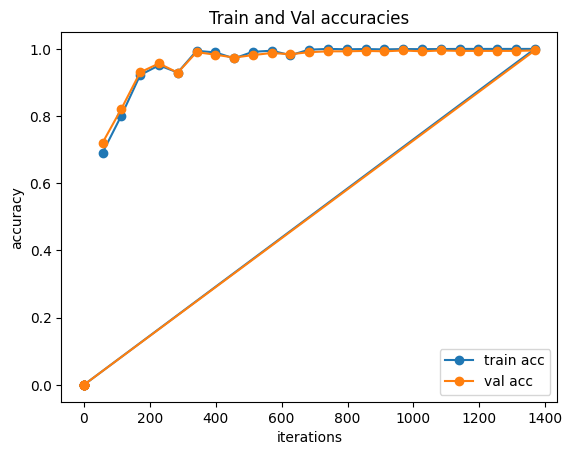

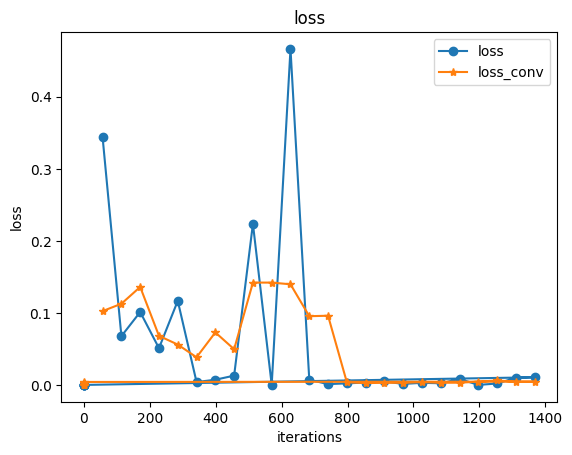

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val accuracies')
plt.plot(iter_history,acc_history,'-o')
plt.plot(iter_history,acc_val_history,'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()
plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## Check acc with graphene data

In [8]:
Graphene_D_xx_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_D_xx_broken.pt')
Graphene_D_yy_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_D_yy_broken.pt')
Graphene_label_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_label_broken.pt')
Graphene_D_xx = torch.load(Graphene_D_xx_path)
Graphene_D_yy = torch.load(Graphene_D_yy_path)
Graphene_labels = torch.load(Graphene_label_path)
t_size = 21
mu_size = 101
print(Graphene_D_xx.shape)
print(Graphene_D_xx.reshape(21,101,15,15)[20,50,7,7])
Graphene_D_broken = ((Graphene_D_xx.reshape(t_size,mu_size,1,mu_steps,B_steps) + Graphene_D_xx.reshape(t_size,1,mu_size,mu_steps,B_steps))*(Graphene_D_yy.reshape(t_size,mu_size,1,mu_steps,B_steps) + Graphene_D_yy.reshape(t_size,1,mu_size,mu_steps,B_steps))).reshape(-1,1,mu_steps,B_steps)
Graphene_labels_broken = (Graphene_labels.reshape(t_size,mu_size,1)+Graphene_labels.reshape(t_size,1,mu_size)).reshape(-1)

torch.Size([2121, 1, 15, 15])
tensor(1.0519)


In [ ]:
print('max:',Graphene_D_broken.max(),'min:',Graphene_D_broken.min())

max: tensor(55.4846) min: tensor(0.0002)


In [12]:
from Training_loops import *
batch_size = 50
print(Graphene_D_broken.shape)
Graphene_Data = Superfluid_Dataset(Graphene_D_broken,Graphene_labels_broken,train=True)
Graphene_loader = torch.utils.data.DataLoader(dataset=Graphene_Data,batch_size=batch_size,shuffle=True)
acc_Graphene= check_accuary(Graphene_loader,my_vgg,verbose=True)

torch.Size([214221, 1, 15, 15])
Got 199667 / 214221 correct 0.93
Got 71208 / 214221 correct 0.33 preds as 0
Got 34931 / 214221 correct 0.16 preds as 2
Got 2186 / 214221 wrong 0.01 preds as 0
Got 4762 / 214221 wrong 0.02 preds as 1
Got 7606 / 214221 wrong 0.04 preds as 2
Got 0 / 214221 wrong 0.00 preds as 3
Got 0 / 214221 wrong 0.00 preds as 4
Got 0 / 214221 wrong 0.00 preds as 5
Got 0 / 214221 wrong 0.00 preds as 6
Got 0 / 214221 wrong 0.00 preds as larger than 6


In [ ]:
from collections import Counter
broken_counts = Counter(Graphene_labels_broken.tolist())
counts = Counter(Graphene_labels.tolist())
print(broken_counts,counts)

Counter({1.0: 103320, 0.0: 75600, 2.0: 35301}) Counter({0.0: 1260, 1.0: 861})


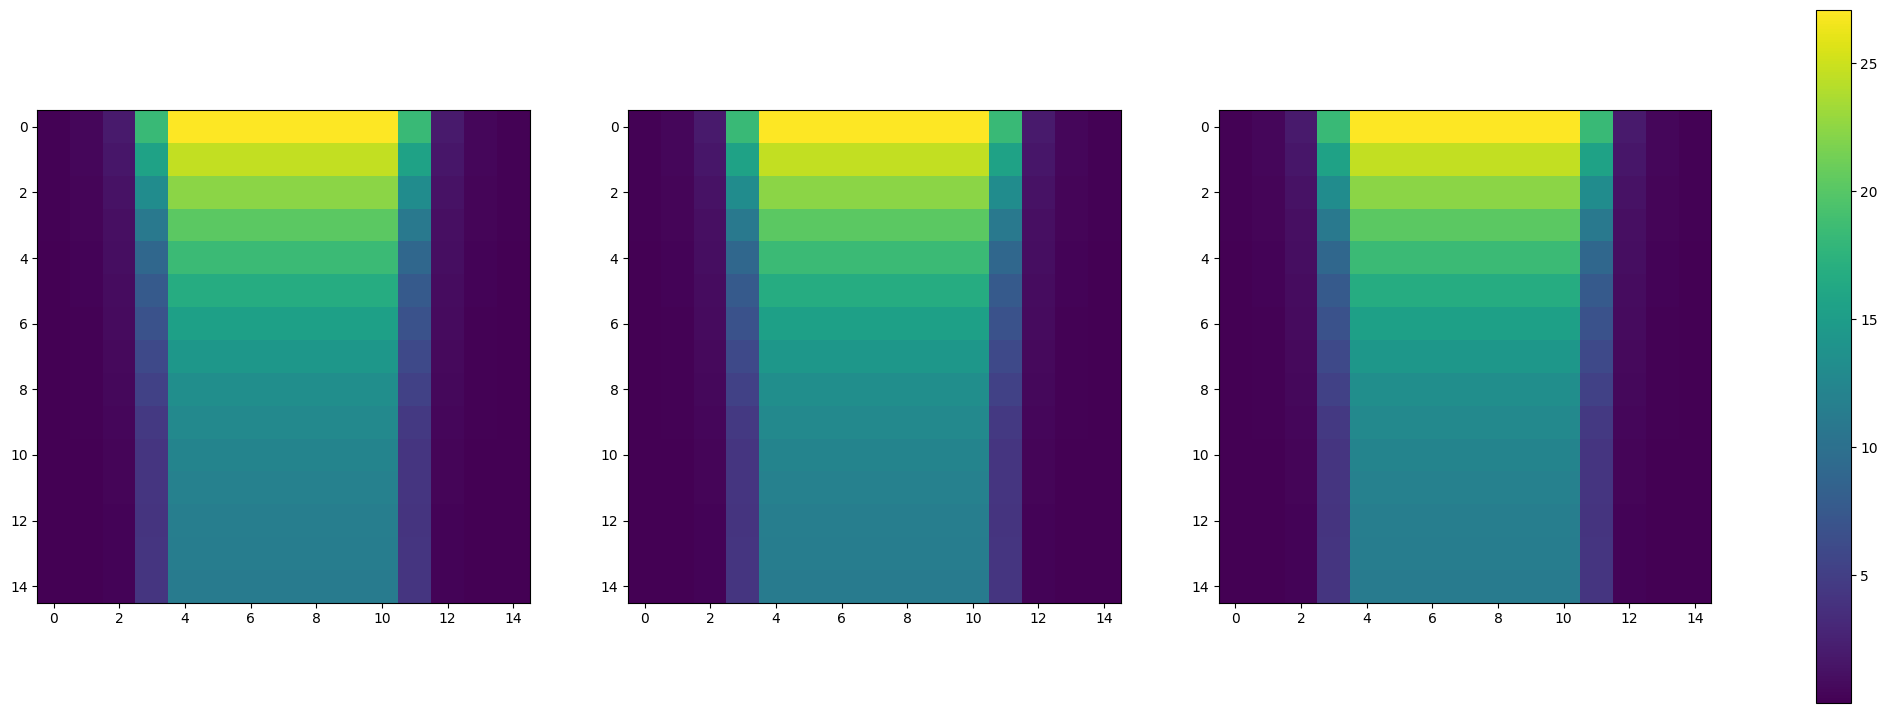

In [ ]:
import matplotlib.pyplot as plt
Graphene_D_test = Graphene_D_broken.reshape(t_size,mu_size,mu_size,mu_steps,B_steps)
vmax = torch.max(Graphene_D_test).item()
vmin = torch.min(Graphene_D_test).item()
fig,ax = plt.subplots(1,3)
fig.set_figwidth(27)
fig.set_figheight(9)
# ax[0].imshow(Graphene_D_test[0,50,50],vmax=vmax,vmin=vmin)
# ax[1].imshow(Graphene_D_test[1,50,50],vmax=vmax,vmin=vmin)
# im=ax[2].imshow(Graphene_D_test[2,50,50],vmax=vmax,vmin=vmin)
ax[0].imshow(Graphene_D_test[0,50,0])
ax[1].imshow(Graphene_D_test[1,50,0])
im=ax[2].imshow(Graphene_D_test[2,50,0])
plt.colorbar(im,ax=ax)

In [ ]:
scorce = my_vgg(Graphene_D_test[20,50,0].reshape(1,1,15,15).to('cuda'))
preds = torch.argmax(scorce,dim=1)
print(preds)
scorce = my_vgg(Graphene_D_test_a[1,250,0].reshape(1,1,15,15).to('cuda'))
preds = torch.argmax(scorce,dim=1)
print(preds)

tensor([2], device='cuda:0')
tensor([1], device='cuda:0')


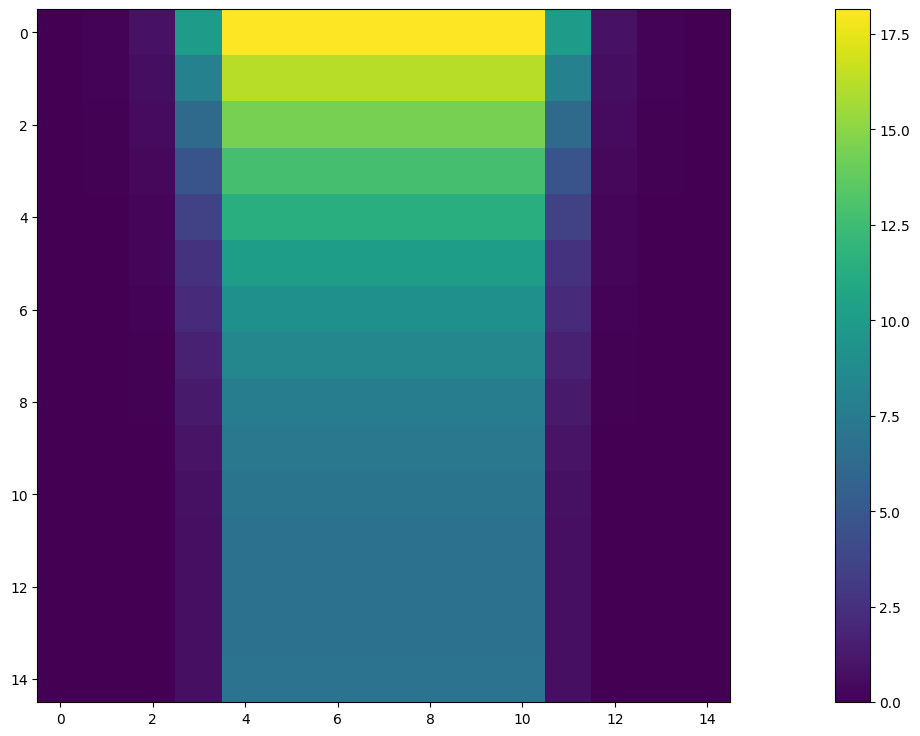

In [ ]:
import matplotlib.pyplot as plt
Graphene_D_test_a = D_total_off.reshape(winding_u,mu_random,mu_random,mu_steps,B_steps)
vmax = torch.max(Graphene_D_test_a).item()
vmin = torch.min(Graphene_D_test_a).item()
fig,ax = plt.subplots(1,1)
fig.set_figwidth(27)
fig.set_figheight(9)
im=ax.imshow(Graphene_D_test_a[1,250,0])
plt.colorbar(im,ax=ax)

# Fully connected neural network

In [ ]:
from Superfluid_Neural_network import *
#my_fc = threelayers_fc_block(in_neurals=B_steps,med_neurals=1024,out_neurals=1)
my_fc = torch.nn.Sequential(
    torch.nn.Linear(B_steps,512,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1024,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(1024,512,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1,bias=True)
)
my_fc.apply(weight_init)

Sequential(
  (0): Linear(in_features=100, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=1, bias=True)
)